In [1]:
# The codes are referenced from Dr.Prashanth Nayak: Data Mining andMachine Learning 1, PGDA. Lecture Material. Year 2023
# The code is also referenced from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
# x19205040 Min Chen

#1 Import libries
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [3]:
import xgboost as xgb
#from tpot import TPOTClassifier
#from mlxtend.classifier import StackingCVClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression #SGDClassifie

In [4]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.pipeline import make_pipeline
from scipy.stats import uniform, randint

In [5]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE
import hyperopt 
from hyperopt.pyll import scope
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

In [6]:
#2 Dataset General Information
ccFraud = pd.read_csv('ccFraud.csv')

In [7]:
ccFraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [8]:
ccFraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
info = ccFraud.describe()
info.style.background_gradient(cmap='BuPu')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [10]:
#check if there is null
print(ccFraud.isnull().sum()) 

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [11]:
# check amount of transactions of Fraudulent
ccFraud["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

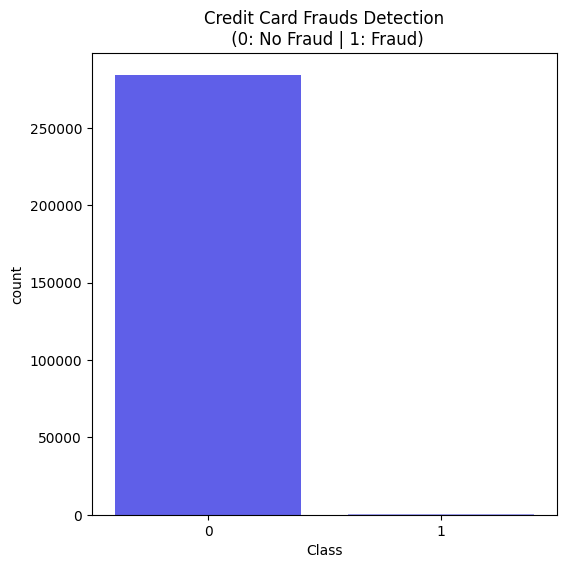

In [12]:
#Plot check Fraud or not Fraud
sns.set_palette("bwr")
fig, ax = plt.subplots(figsize=(6,6))
bar = sns.countplot(x=ccFraud["Class"],ax=ax)
bar.set_title('Credit Card Frauds Detection\n (0: No Fraud | 1: Fraud)')
plt.show()

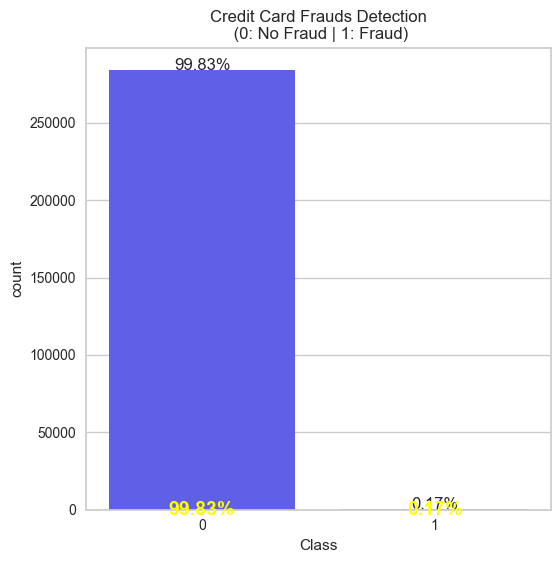

In [76]:
sns.set_palette("bwr")
fig, ax = plt.subplots(figsize=(6,6))
bar = sns.countplot(x=ccFraud["Class"],ax=ax)
bar.set_title('Credit Card Frauds Detection\n (0: No Fraud | 1: Fraud)')

# Add percentage values to the bars
for p in bar.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 2, '{:.2f}%'.format(height/len(ccFraud)*100), ha="center")

# Add specific percentage values to the bars
ax.text(0, 0, '99.83%', ha='center', va='center', fontweight='bold', fontsize=14, color='yellow')
ax.text(1, 0, '0.17%', ha='center', va='center', fontweight='bold', fontsize=14, color='yellow')

plt.show()


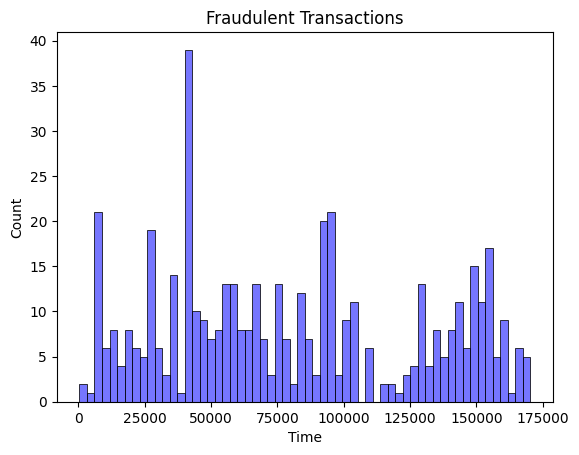

In [13]:
#check fraudulent transations
hist = sns.histplot(ccFraud["Time"][ccFraud.Class == 1], bins=60)
hist.set_title("Fraudulent Transactions")
plt.show()

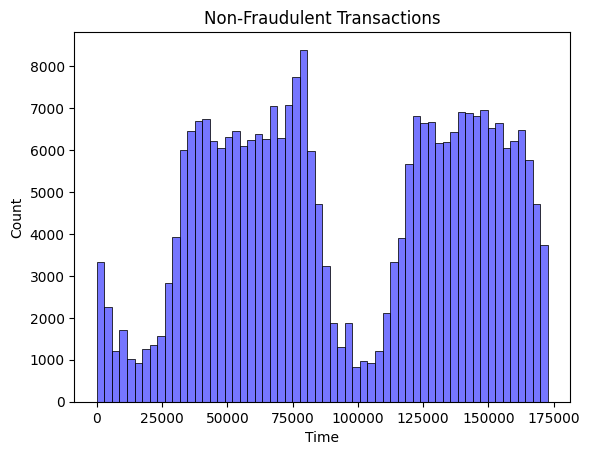

In [14]:
hist = sns.histplot(ccFraud["Time"][ccFraud.Class == 0], bins=60)
hist.set_title("Non-Fraudulent Transactions")
plt.show()

Text(0.5, 1.0, 'Logarithm of Credit Card Transaction Amount')

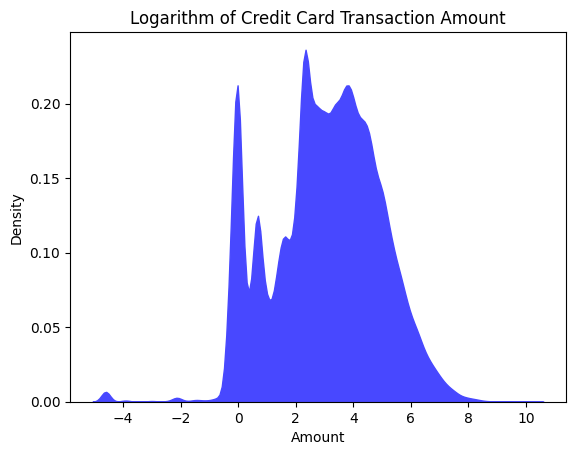

In [15]:
#check transaction amount, apply no.log for highly skewed data
amt=ccFraud["Amount"] 
data_to_plot = np.log(amt)
plot = data_to_plot[~np.isinf(data_to_plot)]
p = sns.kdeplot(x=plot, fill=True, alpha=1) 
p.set_title('Logarithm of Credit Card Transaction Amount')

In [16]:
#3 Prepare data for modelling, split the dataset into train and test
X = ccFraud.drop("Class", axis=1).values
y=ccFraud["Class"].values
rand_state=42  #set a seed, just incase it is different each time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=rand_state, stratify=y)

In [17]:
# scale the data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (227845, 30)
X_test:  (56962, 30)
y_train:  (227845,)
y_test:  (56962,)


In [19]:
#4 Naive Bayers
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(X_train, y_train)
predNaive = naive.predict(X_test)
predNaive

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [20]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
accuracy_score(y_test, predNaive) 

0.9764053228468101

In [23]:
confusion_matrix(y_test, predNaive)

array([[55535,  1329],
       [   15,    83]], dtype=int64)

In [24]:
from yellowbrick.classifier import ConfusionMatrix

0.9764053228468101

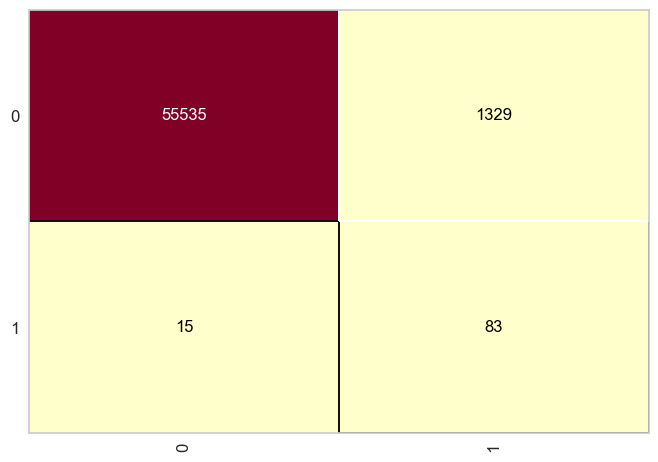

In [25]:
cm = ConfusionMatrix(naive)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)


In [26]:
print(classification_report(y_test, predNaive))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.85      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
rmseNiave = mean_squared_error(y_test, predNaive, squared=False)

print(f"RMSE of the NB model: {rmseNiave:.3f}")

RMSE of the NB model: 0.154


In [29]:
#5 Logistic Regression
lr = LogisticRegression(class_weight= {0: .5, 1: .5},random_state =1)

In [30]:
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.5, 1: 0.5}, random_state=1)

In [31]:
predLr = lr.predict(X_test)
predLr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
accuracy_score(y_test, predLr)

0.9991573329588147

0.9991573329588147

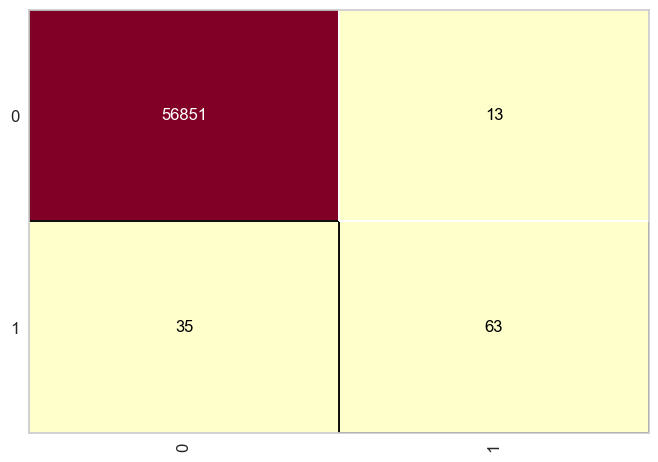

In [34]:
cm = ConfusionMatrix(lr)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [35]:
print(classification_report(y_test, predLr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [36]:
rmseLr = mean_squared_error(y_test, predLr, squared=False)

print(f"RMSE of the LR model: {rmseLr:.3f}")

RMSE of the LR model: 0.029


In [37]:
# The importance of coefficients of logistic regression
coef = pd.DataFrame(zip(X_train, np.transpose(lr.coef_.tolist()[0])), columns=['features', 'coef'])

coef.sort_values(by = 'coef', ascending = False)

,features,coef
4,"[-0.2988864875023492, -0.2090970879192025, -0....",1.198961
22,"[0.6658640293177974, -0.6590645911711545, -0.9...",0.633108
5,"[-0.06343967299379816, 0.5823090851822622, -1....",0.211628
12,"[0.8948505919939861, 0.8843677337276983, -0.18...",0.184913
1,"[0.4659838376245067, 0.9020125821415435, -0.08...",0.176882
21,"[0.13952969366660403, 0.8720466504014155, 0.60...",0.154872
29,"[-0.9847655515880473, 0.5178547244905164, 0.09...",0.069830
2,"[-0.5122862243939109, -0.4520719932344717, 0.3...",0.057175
24,"[0.8859941740274384, -0.7168346365267161, 1.21...",0.051056
18,"[0.6314132681826724, -0.2341409411750154, 0.96...",0.038166


In [38]:
#6 knn
from sklearn.neighbors import KNeighborsClassifier

In [39]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
predKnn = knn.predict(X_test)
predKnn

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [41]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [42]:
accuracy_score(y_test,predKnn)

0.9994908886626171

0.9994908886626171

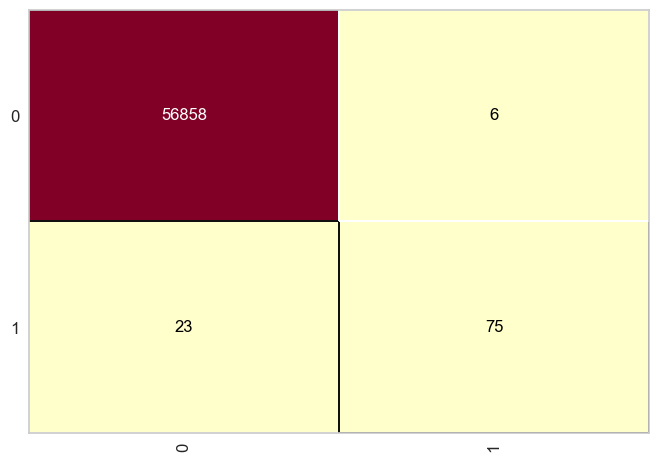

In [43]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(knn)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [44]:
print(classification_report(y_test, predKnn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [45]:
rmseKnn = mean_squared_error(y_test, predKnn, squared=False)

print(f"RMSE of the KNN model: {rmseKnn:.3f}")

RMSE of the KNN model: 0.023


In [46]:
#7 Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [47]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [48]:
predTree = tree.predict(X_test)
predTree

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [49]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
accuracy_score(y_test, predTree)

0.9993153330290369

0.9993153330290369

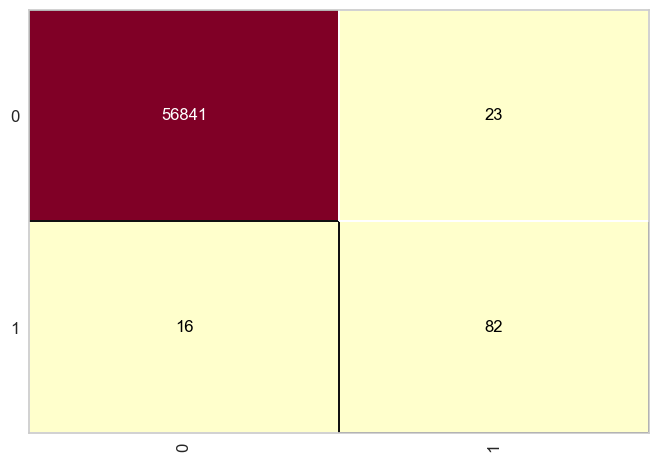

In [51]:
cm = ConfusionMatrix(tree)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [52]:
print(classification_report(y_test, predTree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.84      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [53]:
rmseTree = mean_squared_error(y_test, predTree, squared=False)

print(f"RMSE of the DT model: {rmseTree:.3f}")

RMSE of the DT model: 0.026


In [54]:
#8 Random Forest
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 0)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=40, random_state=0)

In [56]:
predRf = rf.predict(X_test)
predRf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [57]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [58]:
accuracy_score(y_test, predRf)

0.9996137776061234

0.9996137776061234

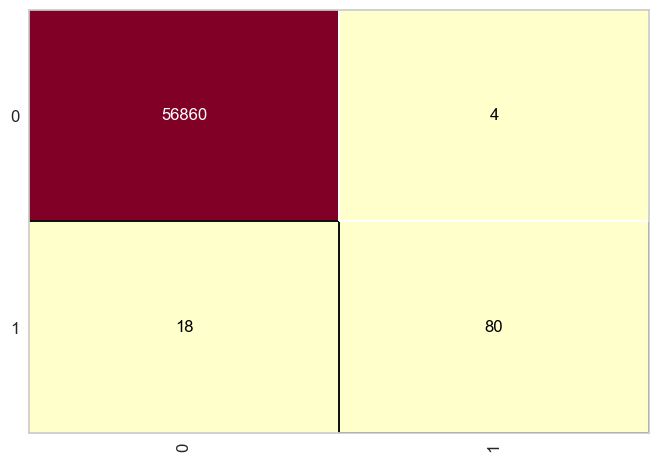

In [59]:
cm = ConfusionMatrix(rf)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [60]:
print(classification_report(y_test, predRf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [61]:
rmseRf = mean_squared_error(y_test, predRf, squared=False)

print(f"RMSE of the RF model: {rmseRf:.3f}")

RMSE of the RF model: 0.020


In [62]:
#9 XGBoost
from xgboost import XGBClassifier

In [63]:
xgb = XGBClassifier(n_estimators=1000, max_depth=15, learning_rate=0.05, objective='binary:logistic', random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [64]:
xgb.score(X_train, y_train)

1.0

In [65]:
xgb.score(X_test, y_test)

0.9995611109160493

In [66]:
predXgb = xgb.predict(X_test)

In [67]:
predXgb

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [69]:
accuracy_score(y_test, predXgb)

0.9995611109160493

0.9995611109160493

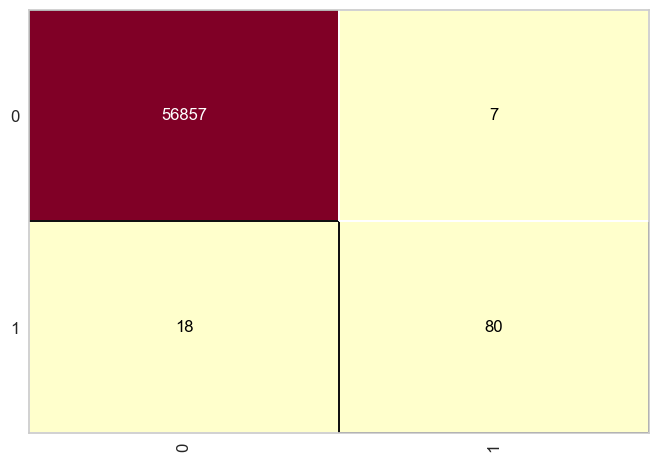

In [70]:
cm = ConfusionMatrix(xgb)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [71]:
print(classification_report(y_test, predXgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [72]:
rmseXgb = mean_squared_error(y_test, predXgb, squared=False)

print(f"RMSE of the XGB model: {rmseXgb:.3f}")

RMSE of the XGB model: 0.021


In [73]:
#Linear SVC will expect each feature to have a similar range of values. SO, scale the data using a StandardScaler.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

classifier = make_pipeline(StandardScaler(),LinearSVC(random_state=rand_state))
classifier.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

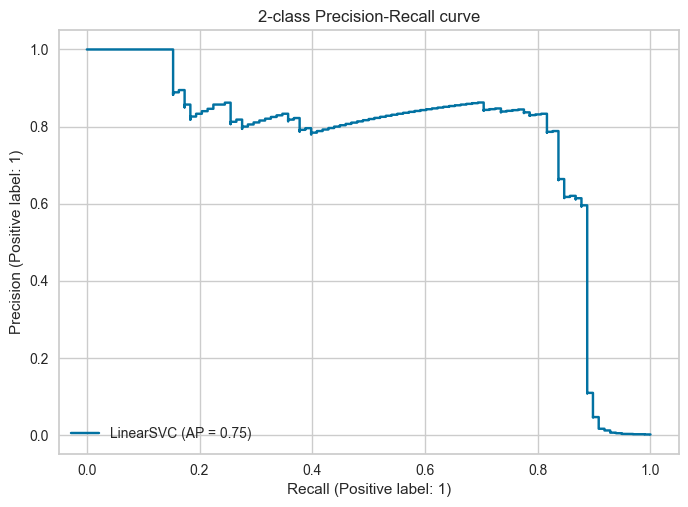

In [74]:
#Plot the Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

LinearSVC,Presision-Recall AP(Average Precision) is 0.75

In [79]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification report data
report_data = {'precision': [1.00, 0.06, 1.00, 0.83, 1.00, 0.93, 1.00, 0.78, 1.00, 0.95, 1.00, 0.92],
               'recall': [0.98, 0.85, 1.00, 0.64, 1.00, 0.77, 1.00, 0.84, 1.00, 0.82, 1.00, 0.82],
               'f1-score': [0.99, 0.11, 1.00, 0.72, 1.00, 0.84, 1.00, 0.81, 1.00, 0.88, 1.00, 0.86],
               'support': [56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98],
               'model': ['Naive Bayes', 'Naive Bayes', 'Logistic regression', 'Logistic regression', 'KNN', 'KNN',
                         'Decision tree', 'Decision tree', 'Random forest', 'Random forest', 'XGBoost', 'XGBoost'],
               'class': ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
              }

# Convert data to DataFrame
report_df = pd.DataFrame(report_data, columns=['model', 'class', 'precision', 'recall', 'f1-score', 'support'])

# Print the DataFrame
print(report_df)


                  model class  precision  recall  f1-score  support
0           Naive Bayes     0       1.00    0.98      0.99    56864
1           Naive Bayes     1       0.06    0.85      0.11       98
2   Logistic regression     0       1.00    1.00      1.00    56864
3   Logistic regression     1       0.83    0.64      0.72       98
4                   KNN     0       1.00    1.00      1.00    56864
5                   KNN     1       0.93    0.77      0.84       98
6         Decision tree     0       1.00    1.00      1.00    56864
7         Decision tree     1       0.78    0.84      0.81       98
8         Random forest     0       1.00    1.00      1.00    56864
9         Random forest     1       0.95    0.82      0.88       98
10              XGBoost     0       1.00    1.00      1.00    56864
11              XGBoost     1       0.92    0.82      0.86       98


In [83]:
import pandas as pd

# Classification report data
report_data = {'precision': [1.00, 0.06, 1.00, 0.83, 1.00, 0.93, 1.00, 0.78, 1.00, 0.95, 1.00, 0.92],
               'recall': [0.98, 0.85, 1.00, 0.64, 1.00, 0.77, 1.00, 0.84, 1.00, 0.82, 1.00, 0.82],
               'f1-score': [0.99, 0.11, 1.00, 0.72, 1.00, 0.84, 1.00, 0.81, 1.00, 0.88, 1.00, 0.86],
               'support': [56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98],
               'model': ['Naive Bayes', 'Naive Bayes', 'Logistic regression', 'Logistic regression', 'KNN', 'KNN',
                         'Decision tree', 'Decision tree', 'Random forest', 'Random forest', 'XGBoost', 'XGBoost'],
               'class': ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
              }

# Convert data to DataFrame
report_df = pd.DataFrame(report_data, columns=['model', 'class', 'precision', 'recall', 'f1-score', 'support'])

# Pivot DataFrame to wide format
report_df = report_df.pivot(index='model', columns='class')

# Create new DataFrame for average precision
avg_df = report_df.copy()
avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
avg_df['average_precision'] = (avg_df['precision_0'] + avg_df['precision_1']) / 2

# Rename columns
report_df.columns = ['_'.join(col).strip() for col in report_df.columns.values]

# Create new DataFrame for final output
output_df = pd.DataFrame()
output_df['Model'] = report_df.index.values
output_df['Class 0 Precision'] = report_df['precision_0'].values
output_df['Class 1 Precision'] = report_df['precision_1'].values
output_df['Average Precision'] = avg_df['average_precision'].values

# Set Model column as index
output_df.set_index('Model', inplace=True)

# Print the DataFrame
print('Precison Report')
print('===================================')
print(output_df.to_string())

# Print the DataFrame
#print(output_df)


Precison Report
                     Class 0 Precision  Class 1 Precision  Average Precision
Model                                                                       
Decision tree                      1.0               0.78              0.890
KNN                                1.0               0.93              0.965
Logistic regression                1.0               0.83              0.915
Naive Bayes                        1.0               0.06              0.530
Random forest                      1.0               0.95              0.975
XGBoost                            1.0               0.92              0.960


# Model Evaluation
#1.Naive Bayers: 97.64%  rmse=0.154
#2.Logistic Regression: 99.91%  rmse=0.029
#3.Knn: 99.94% rmse =0.023
#4.Decision Tree: 99.93% rmse=0.026
#5.Random Forest: 99.96% rmse=0.020
#6.XGBoost; 99.95% rmse=0.021
#7.Precision Recall Linear SVC, AP 75%

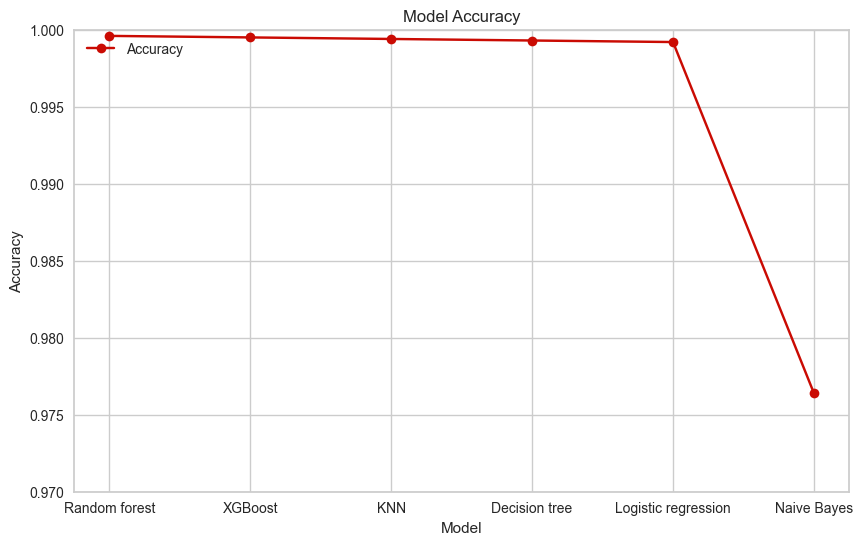

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Model accuracy data
accuracy_data = {'Model': ['Random forest', 'XGBoost', 'KNN', 'Decision tree', 'Logistic regression', 'Naive Bayes'],
                 'Accuracy': [0.9996, 0.9995, 0.9994, 0.9993, 0.9992, 0.9764]}

# Convert data to DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Set Model column as index
accuracy_df.set_index('Model', inplace=True)

# Sort by Accuracy
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Create line plot with different colors
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df.index, accuracy_df['Accuracy'], 'r-o')
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim((0.97, 1.0))
plt.legend(['Accuracy'], loc='upper left')
plt.show()


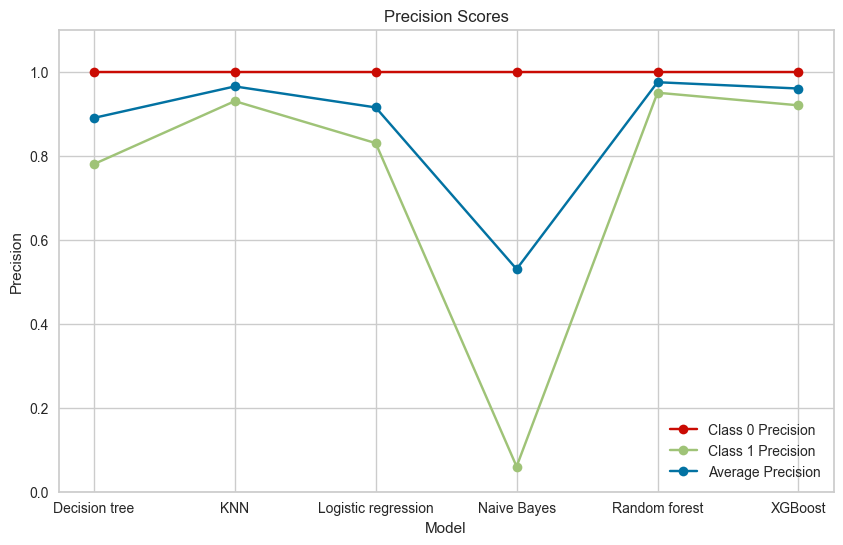

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Precision data
precision_data = {'Model': ['Decision tree', 'KNN', 'Logistic regression', 'Naive Bayes', 'Random forest', 'XGBoost'],
                  'Class 0 Precision': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                  'Class 1 Precision': [0.78, 0.93, 0.83, 0.06, 0.95, 0.92],
                  'Average Precision': [0.890, 0.965, 0.915, 0.530, 0.975, 0.960]}

# Convert data to DataFrame
precision_df = pd.DataFrame(precision_data)

# Set Model column as index
precision_df.set_index('Model', inplace=True)

# Create line plot with different colors
plt.figure(figsize=(10, 6))
plt.plot(precision_df.index, precision_df['Class 0 Precision'], 'r-o')
plt.plot(precision_df.index, precision_df['Class 1 Precision'], 'g-o')
plt.plot(precision_df.index, precision_df['Average Precision'], 'b-o')
plt.title('Precision Scores')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim((0, 1.1))
plt.legend(['Class 0 Precision', 'Class 1 Precision', 'Average Precision'], loc='lower right')
plt.show()


In [81]:
import pandas as pd

# Recall report data
report_data = {'recall': [0.98, 0.85, 1.00, 0.64, 1.00, 0.77, 1.00, 0.84, 1.00, 0.82, 1.00, 0.82],
               'support': [56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98],
               'model': ['Naive Bayes', 'Naive Bayes', 'Logistic regression', 'Logistic regression', 'KNN', 'KNN',
                         'Decision tree', 'Decision tree', 'Random forest', 'Random forest', 'XGBoost', 'XGBoost'],
               'class': ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
              }

# Convert data to DataFrame
report_df = pd.DataFrame(report_data, columns=['model', 'class', 'recall', 'support'])

# Pivot DataFrame to wide format
report_df = report_df.pivot(index='model', columns='class')

# Create new DataFrame for average recall
avg_df = report_df.copy()
avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
avg_df['average_recall'] = (avg_df['recall_0'] + avg_df['recall_1']) / 2

# Rename columns
report_df.columns = ['_'.join(col).strip() for col in report_df.columns.values]

# Create new DataFrame for final output
output_df = pd.DataFrame()
output_df['Model'] = report_df.index.values
output_df['Class 0 Recall'] = report_df['recall_0'].values
output_df['Class 1 Recall'] = report_df['recall_1'].values
output_df['Average Recall'] = avg_df['average_recall'].values

# Set Model column as index
output_df.set_index('Model', inplace=True)

# Print the DataFrame
print('Recall Report')
print('===================================')
print(output_df.to_string())


Recall Report
                     Class 0 Recall  Class 1 Recall  Average Recall
Model                                                              
Decision tree                  1.00            0.84           0.920
KNN                            1.00            0.77           0.885
Logistic regression            1.00            0.64           0.820
Naive Bayes                    0.98            0.85           0.915
Random forest                  1.00            0.82           0.910
XGBoost                        1.00            0.82           0.910


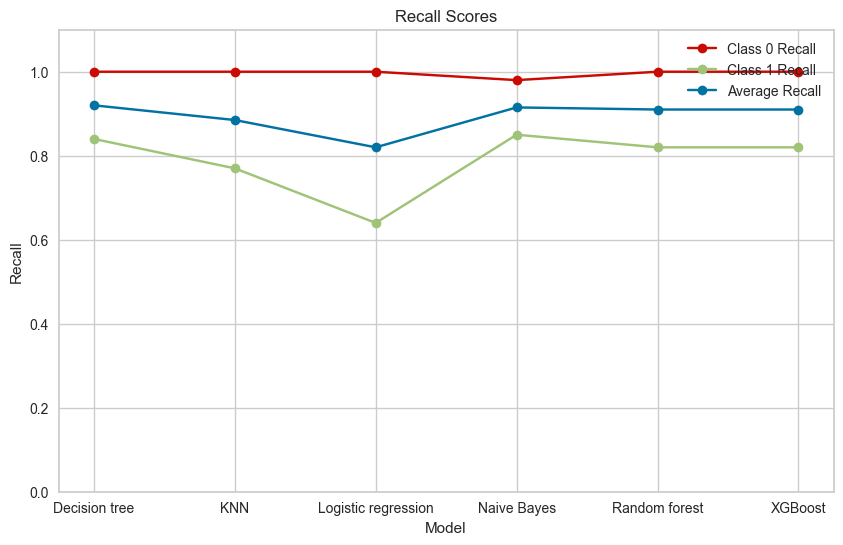

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Recall data
recall_data = {'Model': ['Decision tree', 'KNN', 'Logistic regression', 'Naive Bayes', 'Random forest', 'XGBoost'],
                  'Class 0 Recall': [1.00, 1.00, 1.00, 0.98, 1.00, 1.00],
                  'Class 1 Recall': [0.84, 0.77, 0.64, 0.85, 0.82, 0.82],
                  'Average Recall': [0.920, 0.885, 0.820, 0.915, 0.910, 0.910]}

# Convert data to DataFrame
recall_df = pd.DataFrame(recall_data)

# Set Model column as index
recall_df.set_index('Model', inplace=True)

# Create line plot with different colors
plt.figure(figsize=(10, 6))
plt.plot(recall_df.index, recall_df['Class 0 Recall'], 'r-o')
plt.plot(recall_df.index, recall_df['Class 1 Recall'], 'g-o')
plt.plot(recall_df.index, recall_df['Average Recall'], 'b-o')
plt.title('Recall Scores')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim((0, 1.1))
plt.legend(['Class 0 Recall', 'Class 1 Recall', 'Average Recall'], loc='lower right')
plt.show()


In [82]:
import pandas as pd

# F1-score report data
report_data = {'f1-score': [0.99, 0.11, 1.00, 0.72, 1.00, 0.84, 1.00, 0.81, 1.00, 0.88, 1.00, 0.86],
               'support': [56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98, 56864, 98],
               'model': ['Naive Bayes', 'Naive Bayes', 'Logistic regression', 'Logistic regression', 'KNN', 'KNN',
                         'Decision tree', 'Decision tree', 'Random forest', 'Random forest', 'XGBoost', 'XGBoost'],
               'class': ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
              }

# Convert data to DataFrame
report_df = pd.DataFrame(report_data, columns=['model', 'class', 'f1-score', 'support'])

# Pivot DataFrame to wide format
report_df = report_df.pivot(index='model', columns='class')

# Create new DataFrame for average F1-score
avg_df = report_df.copy()
avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
avg_df['average_f1-score'] = (avg_df['f1-score_0'] + avg_df['f1-score_1']) / 2

# Rename columns
report_df.columns = ['_'.join(col).strip() for col in report_df.columns.values]

# Create new DataFrame for final output
output_df = pd.DataFrame()
output_df['Model'] = report_df.index.values
output_df['Class 0 F1-score'] = report_df['f1-score_0'].values
output_df['Class 1 F1-score'] = report_df['f1-score_1'].values
output_df['Average F1-score'] = avg_df['average_f1-score'].values

# Set Model column as index
output_df.set_index('Model', inplace=True)

# Print the DataFrame
print('F1-score Report')
print('===================================')
print(output_df.to_string())


F1-score Report
                     Class 0 F1-score  Class 1 F1-score  Average F1-score
Model                                                                    
Decision tree                    1.00              0.81             0.905
KNN                              1.00              0.84             0.920
Logistic regression              1.00              0.72             0.860
Naive Bayes                      0.99              0.11             0.550
Random forest                    1.00              0.88             0.940
XGBoost                          1.00              0.86             0.930


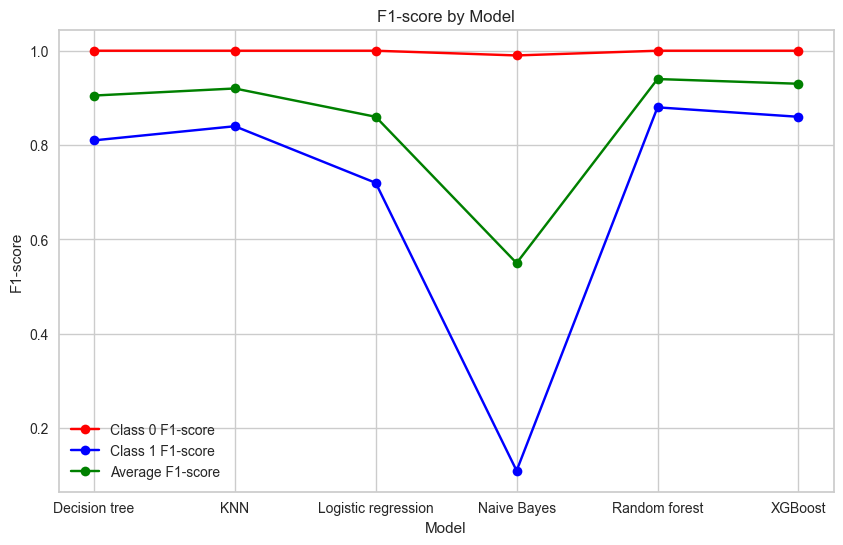

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for F1-score
f1_data = {'Model': ['Decision tree', 'KNN', 'Logistic regression', 'Naive Bayes', 'Random forest', 'XGBoost'],
           'Class 0 F1-score': [1.00, 1.00, 1.00, 0.99, 1.00, 1.00],
           'Class 1 F1-score': [0.81, 0.84, 0.72, 0.11, 0.88, 0.86],
           'Average F1-score': [0.905, 0.920, 0.860, 0.550, 0.940, 0.930]}

# Create a DataFrame from the data
f1_df = pd.DataFrame(f1_data)
f1_df = f1_df.set_index('Model')

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'magenta']
for i, col in enumerate(f1_df.columns):
    ax.plot(f1_df.index, f1_df[col], marker='o', color=colors[i], label=col)

# Set chart properties
ax.set_title('F1-score by Model')
ax.set_xlabel('Model')
ax.set_ylabel('F1-score')
ax.legend(loc='best')

# Display the chart
plt.show()


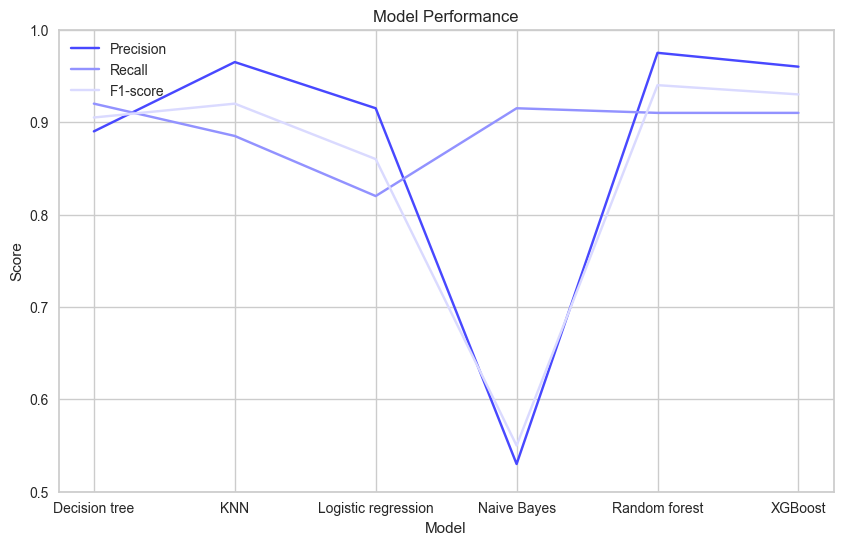

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Precision, recall, and F1-score data
precision_data = {'Model': ['Decision tree', 'KNN', 'Logistic regression', 'Naive Bayes', 'Random forest', 'XGBoost'],
                  'Average Precision': [0.890, 0.965, 0.915, 0.530, 0.975, 0.960]}
recall_data = {'Model': ['Decision tree', 'KNN', 'Logistic regression', 'Naive Bayes', 'Random forest', 'XGBoost'],
               'Average Recall': [0.920, 0.885, 0.820, 0.915, 0.910, 0.910]}
f1_data = {'Model': ['Decision tree', 'KNN', 'Logistic regression', 'Naive Bayes', 'Random forest', 'XGBoost'],
           'Average F1-score': [0.905, 0.920, 0.860, 0.550, 0.940, 0.930]}

# Convert data to DataFrames
precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)
f1_df = pd.DataFrame(f1_data)

# Set Model column as index
precision_df.set_index('Model', inplace=True)
recall_df.set_index('Model', inplace=True)
f1_df.set_index('Model', inplace=True)

# Merge DataFrames
metrics_df = pd.concat([precision_df, recall_df, f1_df], axis=1)

# Create line plot
metrics_df.plot(kind='line', figsize=(10, 6))
plt.title('Model Performance')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim((0.5, 1.0))
plt.legend(['Precision', 'Recall', 'F1-score'], loc='upper left')
plt.show()


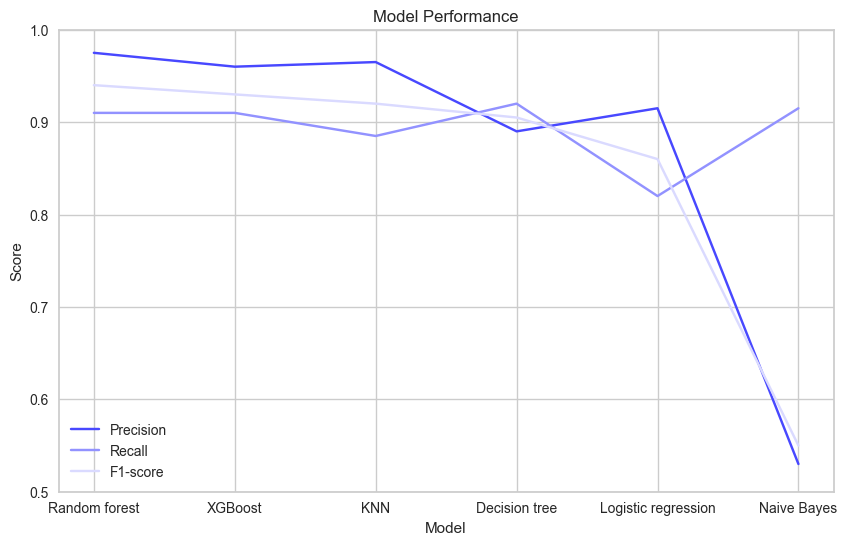

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Precision, recall, and F1-score data
precision_data = {'Model': ['KNN', 'Random forest', 'XGBoost', 'Logistic regression', 'Decision tree', 'Naive Bayes'],
                  'Average Precision': [0.965, 0.975, 0.960, 0.915, 0.890, 0.530]}
recall_data = {'Model': ['Decision tree', 'KNN', 'Naive Bayes', 'Random forest', 'XGBoost', 'Logistic regression'],
               'Average Recall': [0.920, 0.885, 0.915, 0.910, 0.910, 0.820]}
f1_data = {'Model': ['KNN', 'Random forest', 'XGBoost', 'Decision tree', 'Logistic regression', 'Naive Bayes'],
           'Average F1-score': [0.920, 0.940, 0.930, 0.905, 0.860, 0.550]}

# Convert data to DataFrames
precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)
f1_df = pd.DataFrame(f1_data)

# Set Model column as index
precision_df.set_index('Model', inplace=True)
recall_df.set_index('Model', inplace=True)
f1_df.set_index('Model', inplace=True)

# Merge DataFrames
metrics_df = pd.concat([precision_df, recall_df, f1_df], axis=1)

# Sort by Average F1-score
metrics_df = metrics_df.sort_values(by='Average F1-score', ascending=False)

# Create line plot
metrics_df.plot(kind='line', figsize=(10, 6))
plt.title('Model Performance')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim((0.5, 1.0))
plt.legend(['Precision', 'Recall', 'F1-score'], loc='lower left')
plt.show()


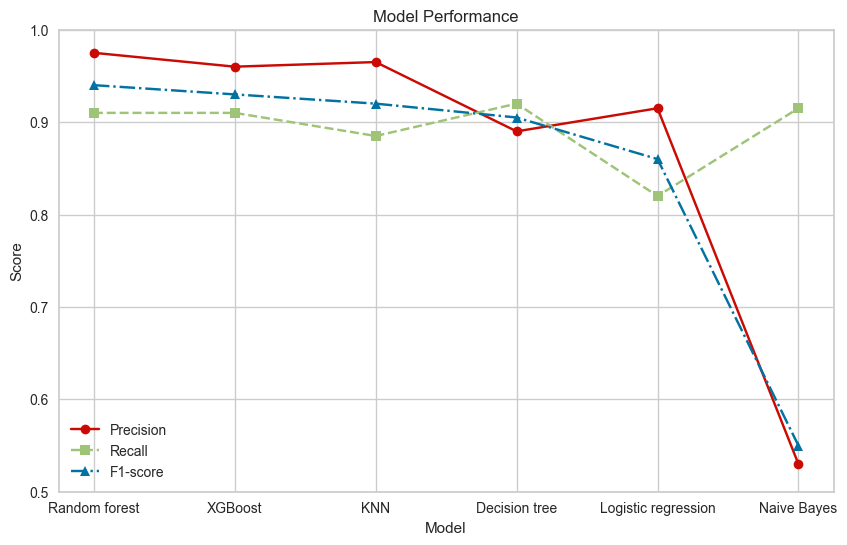

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Precision, recall, and F1-score data
precision_data = {'Model': ['KNN', 'Random forest', 'XGBoost', 'Logistic regression', 'Decision tree', 'Naive Bayes'],
                  'Average Precision': [0.965, 0.975, 0.960, 0.915, 0.890, 0.530]}
recall_data = {'Model': ['Decision tree', 'KNN', 'Naive Bayes', 'Random forest', 'XGBoost', 'Logistic regression'],
               'Average Recall': [0.920, 0.885, 0.915, 0.910, 0.910, 0.820]}
f1_data = {'Model': ['KNN', 'Random forest', 'XGBoost', 'Decision tree', 'Logistic regression', 'Naive Bayes'],
           'Average F1-score': [0.920, 0.940, 0.930, 0.905, 0.860, 0.550]}

# Convert data to DataFrames
precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)
f1_df = pd.DataFrame(f1_data)

# Set Model column as index
precision_df.set_index('Model', inplace=True)
recall_df.set_index('Model', inplace=True)
f1_df.set_index('Model', inplace=True)

# Merge DataFrames
metrics_df = pd.concat([precision_df, recall_df, f1_df], axis=1)

# Sort by Average F1-score
metrics_df = metrics_df.sort_values(by='Average F1-score', ascending=False)

# Create line plot with different colors
plt.figure(figsize=(10, 6))
plt.plot(metrics_df.index, metrics_df['Average Precision'], 'r-o')
plt.plot(metrics_df.index, metrics_df['Average Recall'], 'g--s')
plt.plot(metrics_df.index, metrics_df['Average F1-score'], 'b-.^')
plt.title('Model Performance')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim((0.5, 1.0))
plt.legend(['Precision', 'Recall', 'F1-score'], loc='lower left')
plt.show()
